In [1]:
#import all libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from pylab import show
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading Data
matches = pd.read_csv('datasets/matches.csv')
deliveries = pd.read_csv('datasets/deliveries.csv')

In [3]:
matches = matches.replace(np.nan, '', regex=True)
deliveries = deliveries.replace(np.nan, '', regex=True)

In [4]:
#Part One - Match Total
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

total_and_balls = pd.DataFrame(deliveries)
#Remove super over deliveries as they are significant in predicting team total
indexNames = total_and_balls[ total_and_balls['is_super_over'] == 1 ].index
total_and_balls.drop(indexNames , inplace=True)

#Encoding text features to numerical values
# creating instance of labelencoder
labelencoder = LabelEncoder()

total_and_balls['batsman'] = labelencoder.fit_transform(total_and_balls['batsman'])
labelencoder.fit_transform(total_and_balls['batsman'])

total_and_balls['bowler'] = labelencoder.fit_transform(total_and_balls['bowler'])
labelencoder.fit_transform(total_and_balls['bowler'])

total_and_balls['non_striker'] = labelencoder.fit_transform(total_and_balls['non_striker'])
labelencoder.fit_transform(total_and_balls['non_striker'])

#Remove less significant attributes
total_and_balls = total_and_balls.drop(['is_super_over', 'wide_runs','bye_runs','legbye_runs','noball_runs','penalty_runs','batsman_runs','extra_runs','player_dismissed','dismissal_kind','fielder'], axis=1)

#Populate score field
for id in range(1,637):
    df = total_and_balls.loc[total_and_balls['match_id'] == id]
    total_score = df.loc[df.index[-1], "score"]
    total_and_balls.loc[total_and_balls['match_id'] == id, 'final_score']= total_score

#PCA to identify features that provide more information and remove less significant features
#to reduce complexity
pca = PCA().fit(total_and_balls)

In [62]:
# Identify variance of different features in the dataset
print(pca.components_)

[[ 9.95064112e-01  3.92092440e-06 -1.64385512e-03 -1.57534808e-03
   2.03785773e-04 -2.51896303e-05 -7.07446740e-02 -6.55754385e-02
  -2.27803667e-02  4.00564789e-05 -9.71633082e-04  4.16520175e-03]
 [-6.89923752e-03  5.62524021e-07 -2.32904037e-04 -1.44796013e-04
  -2.17248250e-04 -5.57236122e-05 -7.30418021e-01  6.82963222e-01
   9.92492069e-04  7.04382600e-05 -1.36915918e-03 -4.03432013e-04]
 [-9.68443641e-02  4.22882502e-06 -2.12834470e-03  2.94238912e-05
   2.10880551e-03 -9.90677713e-06 -6.78935731e-01 -7.27016602e-01
  -2.96753326e-02  4.68743377e-05  1.49502157e-02 -1.09028847e-03]
 [-1.97897691e-02  6.50524830e-05 -2.36745162e-04 -2.11674105e-03
   2.46070213e-04 -1.29613436e-05  2.10834981e-02  2.38030926e-02
  -9.99279950e-01  5.20585090e-05  2.86154387e-03 -4.90431952e-03]
 [ 1.56050392e-03 -3.24781192e-04  1.18816690e-04 -7.42972095e-04
   1.07599343e-01  1.48418312e-03  8.81410227e-03  1.15416484e-02
   2.30272378e-03  4.84595779e-03  9.75128010e-01  1.93139201e-01]
 [ 4.

In [5]:
#Generate Feature Set and Labels and split into train and test data

# We would divide the data into train and test data in the ration 4:1
# Before that we'll seperate data corresponding to a macth to evaluate and compare performance of different models
# against projected run rate
eval_match = total_and_balls.loc[total_and_balls['match_id'] == 7]
indexNames = total_and_balls[ total_and_balls['match_id'] == 7 ].index
total_and_balls.drop(indexNames , inplace=True)

In [6]:
# Generate feature and label vectors
from sklearn.model_selection import train_test_split

X = total_and_balls.values[:,:-1]
y = total_and_balls.values[:,-1]

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
# Model 1 - Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1)
cross_val_acc = cross_val_score(model, X_train,y_train, cv=10)

pred = model.fit(X_train,y_train).predict(X_train)
train_acc = r2_score(y_train, pred)
train_acc_mean = mean_squared_error(y_train, pred)
print(f'R square score of the model on train data: {train_acc}')
print(f'Mean squared error of the model on train data: {train_acc_mean}')
print()
print(f'Cross Validation Accuracy of the model: {cross_val_acc.mean()}')
print()
#Testing accuracy
lin = model.fit(X_train,y_train)
pred = lin.predict(X_test)
test_acc = r2_score(y_test, pred)
test_acc_mean = mean_squared_error(y_test, pred)
print(f'R square score of the model on test data: {test_acc}')
print(f'Mean squared error of the model on test data: {test_acc_mean}')

R square score of the model on train data: 0.210787129937
Mean squared error of the model on train data: 678.9248990081413

Cross Validation Accuracy of the model: 0.2105561586301486

R square score of the model on test data: 0.21666095930040563
Mean squared error of the model on test data: 674.876222704071


In [8]:
# Model 2 - K Neighbours Regressor
from sklearn.neighbors import KNeighborsRegressor

# Evaluate cross validation score for Neighbors in range 1-20
accuracies = []
neighbors = []
train_accuracies = []

for index in range(1,21):
        neighbors.append(index)

for neighbor in neighbors:
    model = KNeighborsRegressor(n_neighbors=neighbor, weights='distance', p=2, n_jobs=-1)
    acc = cross_val_score(model, X_train,y_train, cv=10)
    pred = model.fit(X_train,y_train).predict(X_train)
    train_acc = r2_score(y_train, pred)
    accuracies.append(acc.mean())
    train_accuracies.append(train_acc)

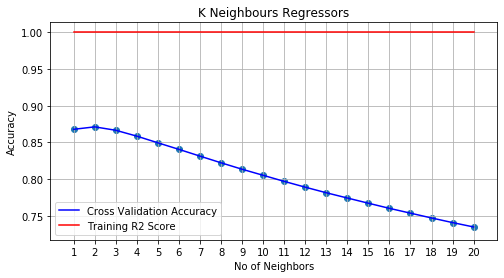

Maximum Cross Validation accuracy - Neighbors: 2, Accuracy: 0.8711764340407484


In [9]:
tck = []
for i in range(1,21):
    tck.append(i)
fig= mp.figure(figsize=(8,4))
mp.grid()
mp.plot(neighbors,accuracies, c='blue', label='Cross Validation Accuracy')
mp.plot(neighbors,train_accuracies, c='red', label='Training R2 Score')
mp.scatter(neighbors,accuracies)
mp.title('K Neighbours Regressors')
mp.xlabel("No of Neighbors")
mp.ylabel("Accuracy")
mp.xticks(tck)
mp.legend()
show()
max_acc = max(accuracies)
max_n = neighbors[accuracies.index(max_acc)]
print(f'Maximum Cross Validation accuracy - Neighbors: {max_n}, Accuracy: {max_acc}')

In [10]:
# Predict the best model on test data
model = KNeighborsRegressor(n_neighbors=2, weights='distance', p=2, n_jobs=-1)
knr = model.fit(X_train,y_train)
pred = knr.predict(X_test)
test_acc = r2_score(y_test, pred)
test_acc_mean = mean_squared_error(y_test, pred)
print(f'R square score of the model on test data: {test_acc}')
print(f'Mean squared error of the model on test data: {test_acc_mean}')

R square score of the model on test data: 0.9044300211769578
Mean squared error of the model on test data: 82.33715283027406


In [11]:
# Model 3 - Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Evaluate accuracy on training set for different parameter values
estimators = [10,50,100,1000]
depths = [10,100]
accuracies = []
outputs = []
train_accuracies = []

for estimator in estimators:
    for depth in depths:
        model = RandomForestRegressor(n_estimators = estimator, max_depth=depth, random_state=0, n_jobs=-1)
        acc = cross_val_score(model, X_train,y_train, cv=10)
        accuracies.append(acc.mean())
        outputs.append((estimator,depth))
        pred = model.fit(X_train,y_train).predict(X_train)
        train_acc = r2_score(y_train, pred)
        train_accuracies.append(train_accuracies)
        print(f'Estimators: {estimator}, Max Dept: {depth}, Training Accuracy: {train_acc}, Cross Validation Accuracy: {acc.mean()}')
        
max_acc = max(accuracies)
index = accuracies.index(max_acc)
est = outputs[index][0]
dep = outputs[index][1]
print(f'Maximum Cross Validation Accuracy: {max_acc}, No of estimators: {est}, Max Depth: {dep}')

Estimators: 10, Max Dept: 10, Training Accuracy: 0.4840049028425052, Cross Validation Accuracy: 0.47693872639379864
Estimators: 10, Max Dept: 100, Training Accuracy: 0.9864901860876021, Cross Validation Accuracy: 0.9286533825286192
Estimators: 50, Max Dept: 10, Training Accuracy: 0.491970066893198, Cross Validation Accuracy: 0.4813928338003521
Estimators: 50, Max Dept: 100, Training Accuracy: 0.9927607632575627, Cross Validation Accuracy: 0.9443133126256662
Estimators: 100, Max Dept: 10, Training Accuracy: 0.4901200917987477, Cross Validation Accuracy: 0.4844173565056498
Estimators: 100, Max Dept: 100, Training Accuracy: 0.9933213438845026, Cross Validation Accuracy: 0.9458115557919676
Estimators: 1000, Max Dept: 10, Training Accuracy: 0.4915126219793772, Cross Validation Accuracy: 0.485660999465179
Estimators: 1000, Max Dept: 100, Training Accuracy: 0.9938383645011852, Cross Validation Accuracy: 0.9468169475827226
Maximum Cross Validation Accuracy: 0.9468169475827226, No of estimators

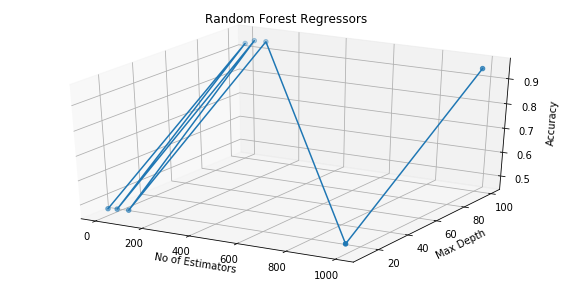

In [13]:
# Visualizing Performance of differernt models
from mpl_toolkits.mplot3d import Axes3D
op_array = []
ests = []
depths = []
for op in outputs:
    l = list(op) 
    ests.append(l[0])
    depths.append(l[1])
fig = mp.figure(figsize=(10,5))
ax = mp.axes(projection="3d")
ax.plot3D(ests, depths, accuracies)
ax.scatter3D(ests, depths, accuracies)
ax.set_xlabel('No of Estimators')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Accuracy')
ax.set_title('Random Forest Regressors')
mp.show()

In [12]:
# Predict the best model on test data
model = RandomForestRegressor(n_estimators =1000, max_depth=100, random_state=0)
rfr = model.fit(X_train,y_train)
pred = rfr.predict(X_test)
test_acc = r2_score(y_test, pred)
test_acc_mean = mean_squared_error(y_test, pred)
print(f'R square score of the model on test data: {test_acc}')
print(f'Mean squared error of the model on test data: {test_acc_mean}')

R square score of the model on test data: 0.9567427701315365
Mean squared error of the model on test data: 37.267740252289755


In [14]:
model.feature_importances_

array([0.5104596 , 0.0173503 , 0.07689576, 0.07390588, 0.06671664,
       0.00576856, 0.0351335 , 0.03760185, 0.04856545, 0.00410225,
       0.12350022])

In [15]:
#Normalizing data for Neural Networks
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
total_and_balls_scaled = scaler.fit_transform(total_and_balls)

X_nn = total_and_balls_scaled[:,:-1]
y_nn = total_and_balls_scaled[:,-1]

# Split into train and test data
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=1)

In [16]:
# Model 4 - Recurrent Neural Networks using LSTM
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN

# reshape input to be 3D [samples, timesteps, features]
X_trains = X_train_nn.reshape((X_train_nn.shape[0], 1, X_train_nn.shape[1]))
X_tests = X_test_nn.reshape((X_test_nn.shape[0], 1, X_test_nn.shape[1]))

#model 1
# A RNN with one LSTM Layers and two dense layers each with 50 nodes
regressor = Sequential()
regressor.add(LSTM(50, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor.add(Dense(50, activation='relu'))
regressor.add(Dense(50, activation='relu'))
regressor.add(Dense(1))
regressor.compile(loss='mean_squared_error', optimizer='adam')
history1 = regressor.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Using TensorFlow backend.


Epoch 1/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0157
Epoch 2/50
120100/120100 [==============================] - 7s 56us/step - loss: 0.0135
Epoch 3/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0133
Epoch 4/50
120100/120100 [==============================] - 7s 57us/step - loss: 0.0130
Epoch 5/50
120100/120100 [==============================] - 7s 59us/step - loss: 0.0127
Epoch 6/50
120100/120100 [==============================] - 7s 57us/step - loss: 0.0124
Epoch 7/50
120100/120100 [==============================] - 7s 57us/step - loss: 0.0120
Epoch 8/50
120100/120100 [==============================] - 7s 56us/step - loss: 0.0117
Epoch 9/50
120100/120100 [==============================] - 7s 56us/step - loss: 0.0113
Epoch 10/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0109
Epoch 11/50
120100/120100 [==============================] - 7s 57us/step - loss: 0.0106
Epoch 12/50
120100/120100 [===

In [36]:
# Model 2
# A RNN with one LSTM Layers and two dense layers each with 100 nodes
regressor2 = Sequential()
regressor2.add(LSTM(100, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor2.add(Dense(50, activation='relu'))
regressor2.add(Dense(50, activation='relu'))
regressor2.add(Dense(1))
regressor2.compile(loss='mean_squared_error', optimizer='adam')
history2 = regressor2.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 13s 109us/step - loss: 0.0154
Epoch 2/50
120100/120100 [==============================] - 13s 104us/step - loss: 0.0135
Epoch 3/50
120100/120100 [==============================] - 13s 106us/step - loss: 0.0132
Epoch 4/50
120100/120100 [==============================] - 13s 108us/step - loss: 0.0128
Epoch 5/50
120100/120100 [==============================] - 13s 104us/step - loss: 0.0124
Epoch 6/50
120100/120100 [==============================] - 13s 106us/step - loss: 0.0121
Epoch 7/50
120100/120100 [==============================] - 13s 107us/step - loss: 0.0116
Epoch 8/50
120100/120100 [==============================] - 13s 107us/step - loss: 0.0111
Epoch 9/50
120100/120100 [==============================] - 13s 108us/step - loss: 0.0106
Epoch 10/50
120100/120100 [==============================] - 12s 104us/step - loss: 0.0102
Epoch 11/50
120100/120100 [==============================] - 13s 105us/step - loss: 0.0098
Epoch 12

In [37]:
# Model 3
# A RNN with just one LSTM Layers with 50 nodes
regressor3 = Sequential()
regressor3.add(LSTM(50, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor3.add(Dense(1))
regressor3.compile(loss='mean_squared_error', optimizer='adam')
history3 = regressor3.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 10s 85us/step - loss: 0.0175
Epoch 2/50
120100/120100 [==============================] - 10s 81us/step - loss: 0.0139
Epoch 3/50
120100/120100 [==============================] - 10s 82us/step - loss: 0.0138
Epoch 4/50
120100/120100 [==============================] - 10s 84us/step - loss: 0.0137
Epoch 5/50
120100/120100 [==============================] - 10s 85us/step - loss: 0.0136
Epoch 6/50
120100/120100 [==============================] - 10s 84us/step - loss: 0.0136
Epoch 7/50
120100/120100 [==============================] - 10s 86us/step - loss: 0.0135
Epoch 8/50
120100/120100 [==============================] - 10s 85us/step - loss: 0.0135
Epoch 9/50
120100/120100 [==============================] - 10s 85us/step - loss: 0.0135
Epoch 10/50
120100/120100 [==============================] - 10s 85us/step - loss: 0.0134
Epoch 11/50
120100/120100 [==============================] - 11s 88us/step - loss: 0.0134
Epoch 12/50
120100/

In [23]:
# Model 4
# A RNN with just one LSTM Layers with 100 nodes
regressor4 = Sequential()
regressor4.add(LSTM(100, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor4.add(Dense(1))
regressor4.compile(loss='mean_squared_error', optimizer='adam')
history4 = regressor4.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 8s 63us/step - loss: 0.0168
Epoch 2/50
120100/120100 [==============================] - 7s 62us/step - loss: 0.0140
Epoch 3/50
120100/120100 [==============================] - 7s 61us/step - loss: 0.0138
Epoch 4/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0137
Epoch 5/50
120100/120100 [==============================] - 7s 59us/step - loss: 0.0136
Epoch 6/50
120100/120100 [==============================] - 7s 61us/step - loss: 0.0136
Epoch 7/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0135
Epoch 8/50
120100/120100 [==============================] - 7s 61us/step - loss: 0.0135
Epoch 9/50
120100/120100 [==============================] - 7s 60us/step - loss: 0.0134
Epoch 10/50
120100/120100 [==============================] - 7s 62us/step - loss: 0.0134
Epoch 11/50
120100/120100 [==============================] - 7s 62us/step - loss: 0.0133
Epoch 12/50
120100/120100 [===

In [26]:
# Model 5
# A RNN with two LSTM Layers with 50 nodes each
regressor5 = Sequential()
regressor5.add(LSTM(50, input_shape=(X_trains.shape[1], X_trains.shape[2]), return_sequences=True))
regressor5.add(LSTM(50))
regressor5.add(Dense(1))
regressor5.compile(loss='mean_squared_error', optimizer='adam')
history5 = regressor5.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 9s 78us/step - loss: 0.0176
Epoch 2/50
120100/120100 [==============================] - 9s 73us/step - loss: 0.0139
Epoch 3/50
120100/120100 [==============================] - 9s 76us/step - loss: 0.0137
Epoch 4/50
120100/120100 [==============================] - 9s 74us/step - loss: 0.0136
Epoch 5/50
120100/120100 [==============================] - 9s 76us/step - loss: 0.0135
Epoch 6/50
120100/120100 [==============================] - 9s 73us/step - loss: 0.0134
Epoch 7/50
120100/120100 [==============================] - 9s 75us/step - loss: 0.0133
Epoch 8/50
120100/120100 [==============================] - 9s 74us/step - loss: 0.0133
Epoch 9/50
120100/120100 [==============================] - 9s 76us/step - loss: 0.0132
Epoch 10/50
120100/120100 [==============================] - 9s 76us/step - loss: 0.0131
Epoch 11/50
120100/120100 [==============================] - 9s 76us/step - loss: 0.0131
Epoch 12/50
120100/120100 [===

In [29]:
# Model 6
# A RNN with two LSTM Layers with 100 nodes
regressor6 = Sequential()
regressor6.add(LSTM(100, input_shape=(X_trains.shape[1], X_trains.shape[2]), return_sequences=True))
regressor6.add(LSTM(100))
regressor6.add(Dense(1))
regressor6.compile(loss='mean_squared_error', optimizer='adam')
history6 = regressor6.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 12s 101us/step - loss: 0.0165
Epoch 2/50
120100/120100 [==============================] - 12s 98us/step - loss: 0.0139
Epoch 3/50
120100/120100 [==============================] - 12s 100us/step - loss: 0.0137
Epoch 4/50
120100/120100 [==============================] - 13s 105us/step - loss: 0.0135
Epoch 5/50
120100/120100 [==============================] - 12s 96us/step - loss: 0.0134
Epoch 6/50
120100/120100 [==============================] - 12s 98us/step - loss: 0.0134
Epoch 7/50
120100/120100 [==============================] - 12s 98us/step - loss: 0.0133
Epoch 8/50
120100/120100 [==============================] - 12s 99us/step - loss: 0.0132
Epoch 9/50
120100/120100 [==============================] - 12s 100us/step - loss: 0.0132
Epoch 10/50
120100/120100 [==============================] - 12s 98us/step - loss: 0.0132
Epoch 11/50
120100/120100 [==============================] - 12s 99us/step - loss: 0.0131
Epoch 12/50
120

In [32]:
# Model 7
# A RNN with one LSTM Layers and three dense layers each with 100 nodes
regressor7 = Sequential()
regressor7.add(LSTM(100, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor7.add(Dense(100, activation='relu'))
regressor7.add(Dense(100, activation='relu'))
regressor7.add(Dense(100, activation='relu'))
regressor7.add(Dense(1))
regressor7.compile(loss='mean_squared_error', optimizer='adam')
history7 = regressor7.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 15s 124us/step - loss: 0.0152
Epoch 2/50
120100/120100 [==============================] - 14s 120us/step - loss: 0.0134
Epoch 3/50
120100/120100 [==============================] - 14s 121us/step - loss: 0.0130
Epoch 4/50
120100/120100 [==============================] - 14s 117us/step - loss: 0.0124
Epoch 5/50
120100/120100 [==============================] - 14s 115us/step - loss: 0.0116
Epoch 6/50
120100/120100 [==============================] - 14s 119us/step - loss: 0.0107
Epoch 7/50
120100/120100 [==============================] - 15s 121us/step - loss: 0.0099
Epoch 8/50
120100/120100 [==============================] - 14s 119us/step - loss: 0.0091
Epoch 9/50
120100/120100 [==============================] - 14s 118us/step - loss: 0.0085
Epoch 10/50
120100/120100 [==============================] - 14s 119us/step - loss: 0.0079
Epoch 11/50
120100/120100 [==============================] - 14s 118us/step - loss: 0.0073
Epoch 12

In [34]:
# Model 8
# A RNN with one LSTM Layers with 200 neurons and three dense layers each with 100 nodes
regressor8 = Sequential()
regressor8.add(LSTM(200, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor8.add(Dense(100, activation='relu'))
regressor8.add(Dense(100, activation='relu'))
regressor8.add(Dense(100, activation='relu'))
regressor8.add(Dense(1))
regressor8.compile(loss='mean_squared_error', optimizer='adam')
history8 = regressor8.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 22s 180us/step - loss: 0.0153
Epoch 2/50
120100/120100 [==============================] - 21s 176us/step - loss: 0.0135
Epoch 3/50
120100/120100 [==============================] - 21s 177us/step - loss: 0.0129
Epoch 4/50
120100/120100 [==============================] - 21s 175us/step - loss: 0.0123
Epoch 5/50
120100/120100 [==============================] - 21s 175us/step - loss: 0.0114
Epoch 6/50
120100/120100 [==============================] - 21s 177us/step - loss: 0.0105
Epoch 7/50
120100/120100 [==============================] - 21s 174us/step - loss: 0.0096
Epoch 8/50
120100/120100 [==============================] - 21s 174us/step - loss: 0.0086
Epoch 9/50
120100/120100 [==============================] - 21s 177us/step - loss: 0.0077
Epoch 10/50
120100/120100 [==============================] - 21s 173us/step - loss: 0.0070
Epoch 11/50
120100/120100 [==============================] - 21s 174us/step - loss: 0.0064
Epoch 12

In [39]:
# Model 9
# A RNN with one LSTM Layers with 200 neurons and three dense layers each with 200 nodes
regressor9 = Sequential()
regressor9.add(LSTM(200, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor9.add(Dense(200, activation='relu'))
regressor9.add(Dense(200, activation='relu'))
regressor9.add(Dense(200, activation='relu'))
regressor9.add(Dense(1))
regressor9.compile(loss='mean_squared_error', optimizer='adam')
history9 = regressor9.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 26s 215us/step - loss: 0.0151
Epoch 2/50
120100/120100 [==============================] - 25s 206us/step - loss: 0.0134
Epoch 3/50
120100/120100 [==============================] - 26s 219us/step - loss: 0.0129
Epoch 4/50
120100/120100 [==============================] - 26s 219us/step - loss: 0.0121
Epoch 5/50
120100/120100 [==============================] - 27s 221us/step - loss: 0.0112
Epoch 6/50
120100/120100 [==============================] - 27s 226us/step - loss: 0.0101
Epoch 7/50
120100/120100 [==============================] - 27s 228us/step - loss: 0.0091
Epoch 8/50
120100/120100 [==============================] - 27s 225us/step - loss: 0.0081
Epoch 9/50
120100/120100 [==============================] - 28s 230us/step - loss: 0.0073
Epoch 10/50
120100/120100 [==============================] - 28s 231us/step - loss: 0.0065
Epoch 11/50
120100/120100 [==============================] - 27s 223us/step - loss: 0.0060
Epoch 12

In [40]:
# Model 10
# A RNN with one LSTM Layers with 300 neurons and three dense layers each with 200 nodes
regressor10 = Sequential()
regressor10.add(LSTM(300, input_shape=(X_trains.shape[1], X_trains.shape[2])))
regressor10.add(Dense(200, activation='relu'))
regressor10.add(Dense(200, activation='relu'))
regressor10.add(Dense(200, activation='relu'))
regressor10.add(Dense(1))
regressor10.compile(loss='mean_squared_error', optimizer='adam')
history10 = regressor10.fit(X_trains, y_train_nn, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
120100/120100 [==============================] - 58s 486us/step - loss: 0.0151
Epoch 2/50
120100/120100 [==============================] - 52s 432us/step - loss: 0.0134
Epoch 3/50
120100/120100 [==============================] - 49s 407us/step - loss: 0.0129
Epoch 4/50
120100/120100 [==============================] - 53s 441us/step - loss: 0.01230s
Epoch 5/50
120100/120100 [==============================] - 52s 434us/step - loss: 0.0116
Epoch 6/50
120100/120100 [==============================] - 53s 439us/step - loss: 0.0106
Epoch 7/50
120100/120100 [==============================] - 54s 446us/step - loss: 0.0097
Epoch 8/50
120100/120100 [==============================] - 55s 457us/step - loss: 0.0088
Epoch 9/50
120100/120100 [==============================] - 54s 446us/step - loss: 0.0079
Epoch 10/50
120100/120100 [==============================] - 55s 457us/step - loss: 0.0071
Epoch 11/50
120100/120100 [==============================] - 52s 436us/step - loss: 0.0065
Epoch 

dict_keys(['loss'])


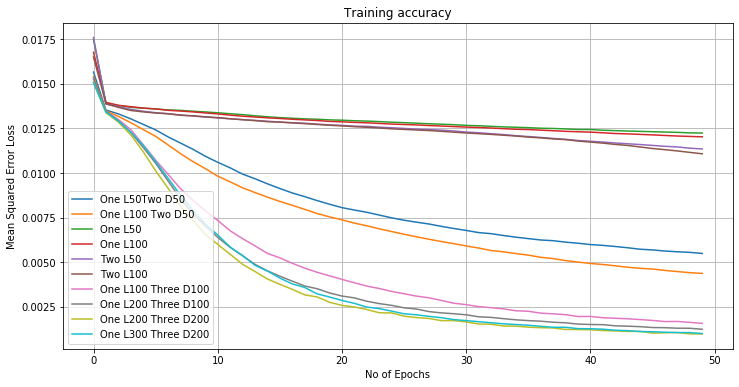

In [41]:
# list all data in history for model 1
print(history1.history.keys())
# summarize history for accuracy
fig= mp.figure(figsize=(12,6))
mp.grid()
mp.plot(history1.history['loss'], label='One L50Two D50', c='#1f77b4')
mp.plot(history2.history['loss'], label='One L100 Two D50', c='#ff7f0e')
mp.plot(history3.history['loss'], label='One L50', c='#2ca02c')
mp.plot(history4.history['loss'], label='One L100', c='#d62728')
mp.plot(history5.history['loss'], label='Two L50', c='#9467bd')
mp.plot(history6.history['loss'], label='Two L100', c='#8c564b')
mp.plot(history7.history['loss'], label='One L100 Three D100', c='#e377c2')
mp.plot(history8.history['loss'], label='One L200 Three D100', c='#7f7f7f')
mp.plot(history9.history['loss'], label='One L200 Three D200', c='#bcbd22')
mp.plot(history10.history['loss'], label='One L300 Three D200', c='#17becf')
mp.title('Training accuracy')
mp.ylabel('Mean Squared Error Loss')
mp.xlabel('No of Epochs')
mp.legend()
mp.show()

In [60]:
# Prediction of best model
#Optimum model is with the configuration One LSTM layer with 200 nodes and Three Dense Layers with 200 ndoes each
pred = regressor8.predict(X_tests)
test_acc = r2_score(y_test_nn, pred)
test_acc_mean = mean_squared_error(y_test_nn, pred)
print(f'R square score of the model on test data: {test_acc}')
print(f'Mean squared error of the model on test data: {test_acc_mean}')

R square score of the model on test data: 0.9241242817444608
Mean squared error of the model on test data: 0.001338420633915955


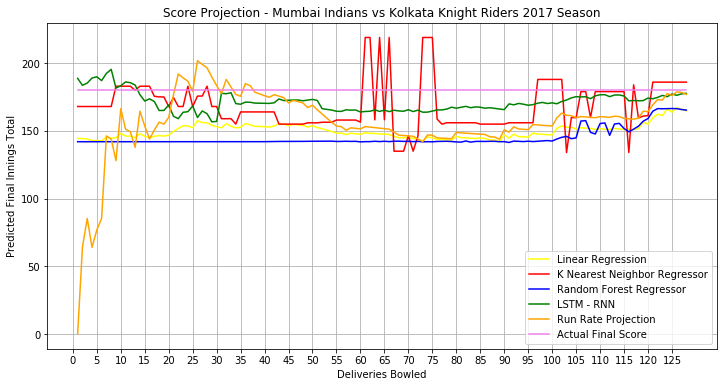

In [59]:
# Evaluating different models performance on the seperated data set
fig= mp.figure(figsize=(12,6))

# eval_match data for first inning
eval_match = eval_match.loc[eval_match['inning'] == 1]
X_eval = eval_match.values[:,:-1]
y_eval = eval_match.values[:,-1]

#Generate balls vector
balls = []
for index in range(1,len(X_eval)+1):
    balls.append(index)
    
#Calculate Runrate Projection
total_deliveries = len(X_eval)
runrate_proj = []
for index in range(len(X_eval)):
    runs = X_eval[index][-1]
    runrate = runs/(index+1)
    runrate_proj.append(runrate*total_deliveries)
    
# Prediction on Linear Regression model
pred_lin = lin.predict(X_eval)

# Prediction on K Nearest Neighbor Regression model
pred_knr = knr.predict(X_eval)

# Prediction on Random Forest Regressor model
pred_rfr = rfr.predict(X_eval)

# Reshape eval features for prediction on  rnn
X_evals_scaled = scaler.fit_transform(X_eval)
X_evals = X_evals_scaled.reshape((X_evals_scaled.shape[0], 1, X_evals_scaled.shape[1]))
pred_rnn_norm = regressor8.predict(X_evals)
pred_rnn = []
#scale back predicted value to normal scale
min_y = min(y_train)
max_y = max(y_train)
diff = max_y - min_y
for i in  range(len(pred_rnn_norm)):
    val = (pred_rnn_norm * diff) + min_y
    pred_rnn.append(val)



#Visualizing Data
mp.grid()
mp.xlabel('Deliveries Bowled')
mp.ylabel('Predicted Final Innings Total')
mp.title('Score Projection - Mumbai Indians vs Kolkata Knight Riders 2017 Season')
mp.plot(balls,pred_lin,c='yellow', label='Linear Regression')
mp.plot(balls,pred_knr,c='red', label='K Nearest Neighbor Regressor')
mp.plot(balls,pred_rfr,c='blue', label='Random Forest Regressor')
mp.plot(balls,pred_rnn[0],c='green', label='LSTM - RNN')
mp.plot(balls,runrate_proj,c='orange', label='Run Rate Projection')
mp.plot(balls,y_eval,c='violet', label='Actual Final Score')
mp.xticks(np.arange(0, max(balls)+1, 5))
mp.legend()
show()